In [2]:
from xcube import open_from_obs
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
from dask.distributed import Client, progress
import graphviz
%matplotlib inline
np.warnings.filterwarnings('ignore')

In [3]:
client = Client()

In [4]:
client

Client Scheduler: tcp://127.0.0.1:54710 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 17.03 GB


In [5]:
#ds = open_from_obs('dcs4cop-obs-01/OLCI-SNS-RAW-CUBE-2.zarr', endpoint_url='http://obs.eu-de.otc.t-systems.com')

In [6]:
ds = xr.open_zarr("C:\\Users\gunnar\src\data\dcs4cop\cube\OLCI-SNS-RAW-CUBE-2.zarr")

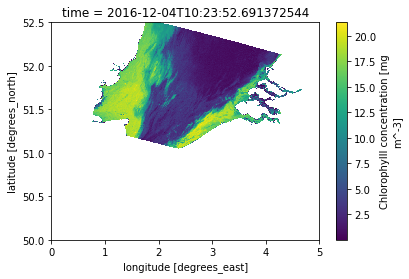

In [7]:
ds.conc_chl.isel(time=9).plot.imshow()

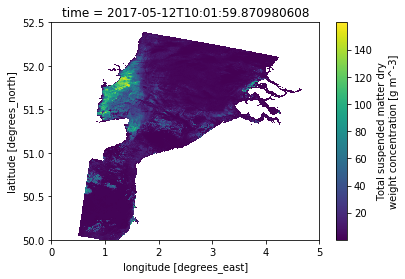

In [8]:
ds.conc_tsm.sel(time=pd.to_datetime('2017-05-12'), method='nearest').plot.imshow()

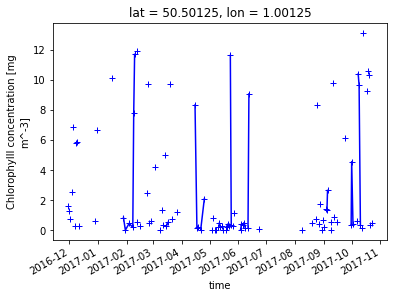

In [9]:
ds.conc_chl.sel(lon=1., lat=50.5, method='nearest').plot.line('b-+')

In [10]:
ds_resampled = ds.resample(time='14d',skipna = True, keep_attrs=True).mean()

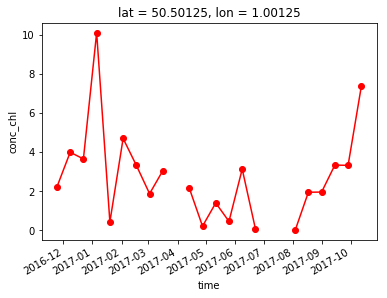

In [11]:
ds_resampled.conc_chl.sel(lon=1., lat=50.5, method='nearest').plot.line('r-o')

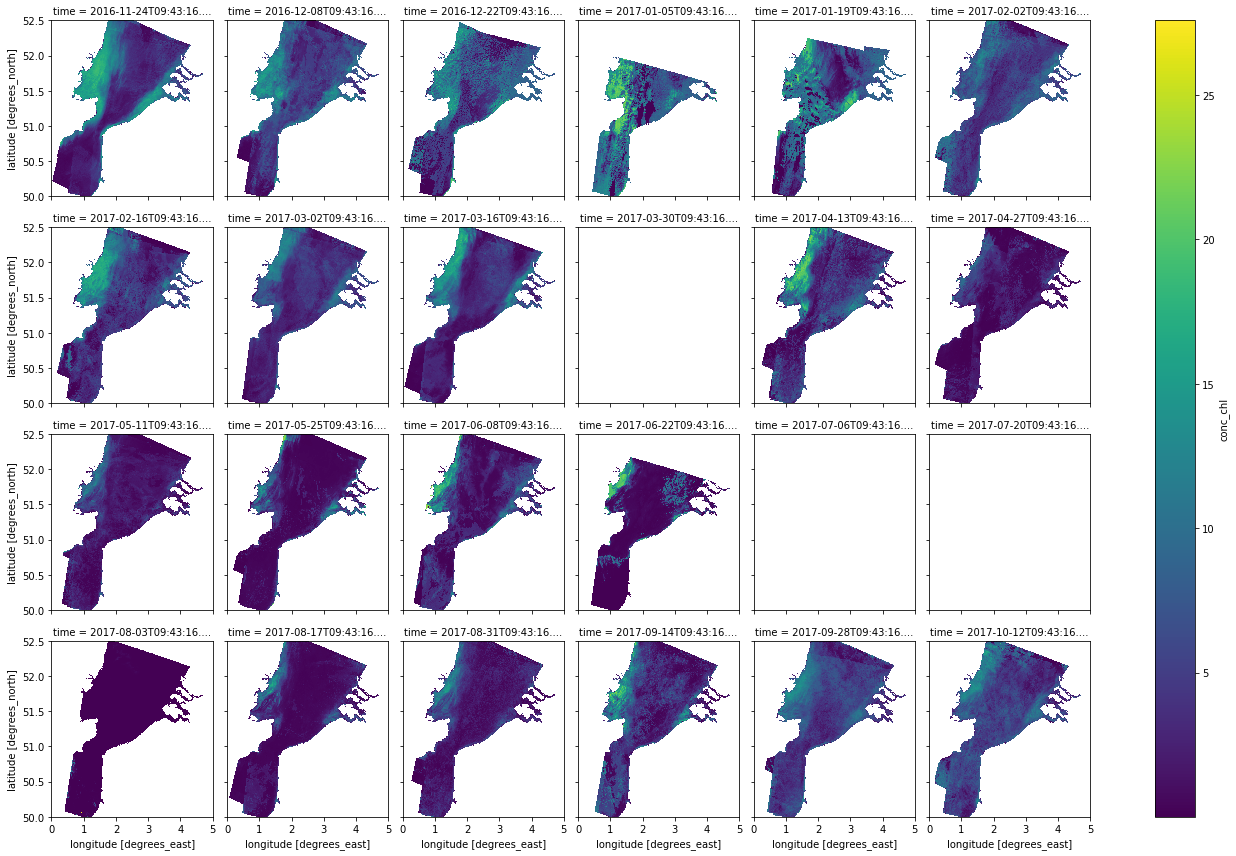

In [12]:
ds_resampled.conc_chl.plot.imshow(x='lon',y='lat',col='time',col_wrap=6)

In [13]:
res = ds.conc_chl.mean(dim='time')

In [14]:
ds_zscore = (ds-ds.mean(dim='time'))/ds.std(dim='time')

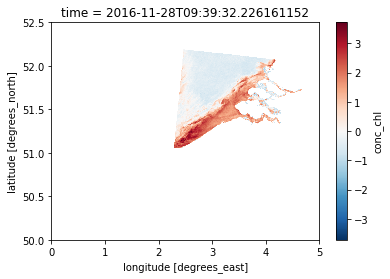

In [15]:
ds_zscore.conc_chl.isel(time=2).plot.imshow()

In [16]:
def above_Nsigma(x,Nsigma):
    return xr.ufuncs.fabs(x)>Nsigma

In [17]:
x_sigma =ds_zscore.apply(above_Nsigma,Nsigma = 1)

# Number of obs > 1 sigma

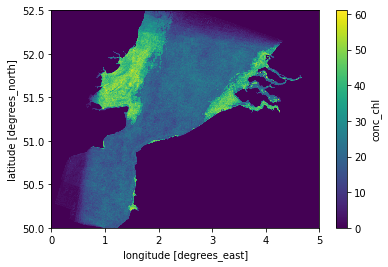

In [18]:
x_sigma.conc_chl.sum(dim="time",skipna = True).plot()

# Map projection

(-1, 5)

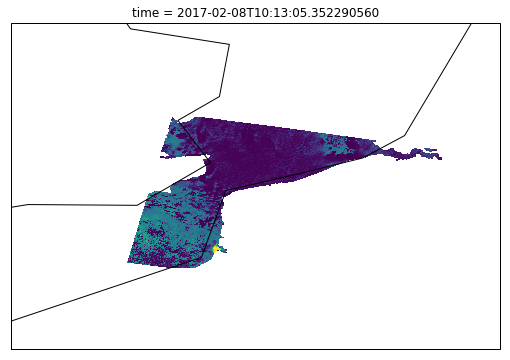

In [19]:
plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ds.conc_chl.isel(time=37).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=False)
ax.coastlines()
ax.set_ylim([49,53])
ax.set_xlim([-1,5])

# Match-up

In [20]:
d = {'lat': np.random.uniform(low=51.5, high=52.5, size = 10), 'lon': np.random.uniform(low=2., high=3., size = 10), 'time': ['2017-01-01 10:12','2017-02-16 09:23','2017-06-18 12:34','2017-08-19 11:11','2017-11-28 08:34','2017-01-01 10:12','2017-02-16 09:23','2017-06-18 12:34','2017-08-19 11:11','2017-11-28 08:34'], 'CHL': np.random.uniform(low=0., high=32., size = 10) }

In [21]:
insitu = pd.DataFrame(d)

In [22]:
insitu.time = pd.to_datetime(insitu.time)

In [23]:
insitu['CHL_SAT'] = ds_resampled.conc_chl.sel_points(lat = insitu.lat.values, lon = insitu.lon.values, time = insitu.time.values,method = "nearest")

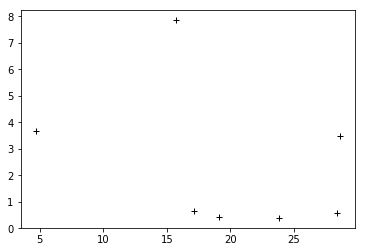

In [24]:
plt.plot(insitu.CHL,insitu.CHL_SAT,'k+')

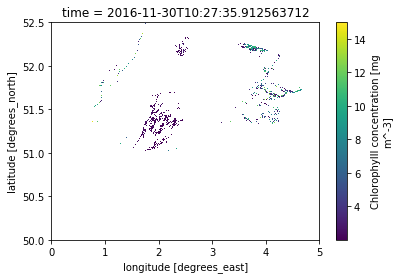

In [25]:
ds.conc_chl.where( (ds.conc_tsm < 15.) & (ds.conc_chl > 2.)).isel(time=4).plot.imshow()

In [26]:
def DAT_corr(ds, var1 = None, var2 = None, dim ='time'):
   
    if not isinstance(ds,xr.Dataset):
        print('Input object ',ds,' is no xarray Dataset!')
        var1 = None

    if var1 is not None:  
        if var2 is None: 
            var2 = var1  
        ds_tmean = ds.mean(skipna=True, dim = dim)
        ds_tstd =  ds.std(skipna=True, dim = dim)
        covar_1 = (ds[var1] - ds_tmean[var1])*(ds[var2] - ds_tmean[var2])
        res = covar_1.mean(dim= 'time', skipna=True)/(ds_tstd[var1]*ds_tstd[var2])
    else: 
        res = None
        
    return res.persist()

In [27]:
ds_corr = DAT_corr(ds,'conc_tsm', 'conc_chl')

In [28]:
ds_corr

<xarray.DataArray (lat: 1000, lon: 2000)>
dask.array<shape=(1000, 2000), dtype=float64, chunksize=(1000, 2000)>
Coordinates:
  * lat      (lat) float64 52.5 52.5 52.49 52.49 52.49 52.49 52.48 52.48 ...
  * lon      (lon) float64 0.00125 0.00375 0.00625 0.00875 0.01125 0.01375 ...

In [ ]:
ds_corr.plot.contourf(levels = np.linspace(.9,1,10))

In [ ]:
np.linspace(-1,1,41)

In [ ]:
ds.c2rcc_flags.isel(time=13).plot.imshow()